# Notebook to explore patient data

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt

### Read in left and right data 

In [4]:
left_path = "Test_data/1_1717404766904_walk_Left.csv"
right_path = "Test_data/1_1717404766904_walk_Right.csv"

left_df = pd.read_csv(left_path)
right_df = pd.read_csv(right_path)

print(right_df.head(5))

   PacketCounter  SampleTimeFine    Quat_W    Quat_X    Quat_Y    Quat_Z  \
0              2       296549695  0.590306  0.309518 -0.652131  0.361194   
1              3       296566362  0.590118  0.309731 -0.652159  0.361270   
2              4       296583029  0.589945  0.309974 -0.652062  0.361519   
3              5       296599696  0.589830  0.310127 -0.652026  0.361641   
4              6       296616363  0.589661  0.310355 -0.651937  0.361883   

      Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y    Gyr_Z   
0  9.860587 -1.035990 -0.432401  0.999286 -0.217413  1.042482  
1  9.838422 -1.032884 -0.404105  0.900306 -0.342224  1.157086  
2  9.852209 -1.016255 -0.422994  0.972367 -0.407793  1.176462  
3  9.862393 -1.022320 -0.422945  1.070694 -0.469340  1.216341  
4  9.868454 -1.009686 -0.410548  1.127042 -0.305585  1.308137  


### read acceleration values

In [23]:
 def vector_magnitude(*args):
    n = len(args[0])
    assert all(len(x) == n for x in args), "Vectors have different lengths"
    vm = np.sqrt(sum(x ** 2 for x in args))
    return vm

In [24]:
left_pc = left_df["PacketCounter"]
left_acc_x = left_df["Acc_X"].to_numpy() / 9.80665
left_acc_y = left_df["Acc_Y"].to_numpy() / 9.80665
left_acc_z = left_df["Acc_Z"].to_numpy() / 9.80665
left_mag = vector_magnitude(left_acc_x, left_acc_y, left_acc_z)

right_pc = right_df["PacketCounter"]
right_acc_x = right_df["Acc_X"].to_numpy() / 9.80665
right_acc_y = right_df["Acc_Y"].to_numpy() / 9.80665
right_acc_z = right_df["Acc_Z"].to_numpy() / 9.80665

right_mag = vector_magnitude(right_acc_x, right_acc_y, right_acc_z)

### Graph Left acceleration

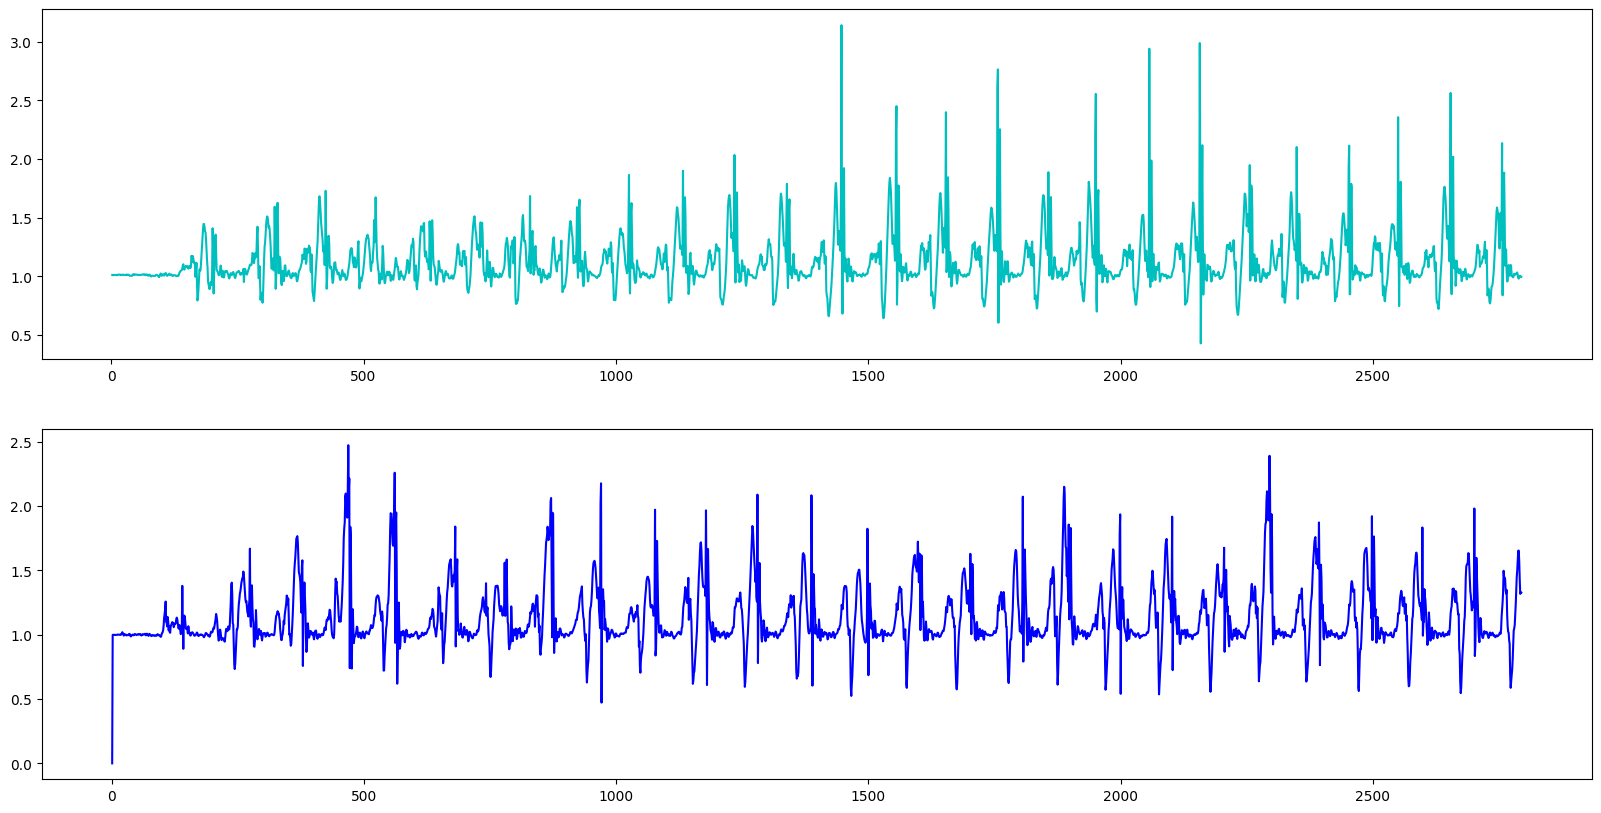

In [26]:
# simple graphs
fig, ax = plt.subplots(2,1, figsize=(20, 10))

ax[0].plot(right_pc, right_mag, color="c")
ax[1].plot(left_pc, left_mag, color="blue")

### Compute loading intensity

In [32]:
# functions for visibility that are in the compute_loading_intensity module
# pass in 3 sensors
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order):
    nyq = 0.5 * sample_rate

    if filter_type == "bandpass":
        nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1], btype=filter_type, analog=False, output='ba', fs=sample_rate)
    else:
        nyq_cutoff = frequency / nyq

    return b, a

def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
    

def compute_fft_mag(data):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    #print(fftpoints)
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) / (fftpoints/2)
    return mag.tolist()


def compute_loading_intensity(fft_magnitudes, sampling_frequency, high_cut_off):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(fft_magnitudes)))))
    LI = 0
    fs = sampling_frequency
    fc = high_cut_off
    kc = int((fftpoints/fs)* fc) + 1

    magnitudes = fft_magnitudes

    f = []
    for i in range(0, int(fftpoints/2)+1):
        f.append((fs*i)/fftpoints)

    for k in range(0, kc):
        LI = LI + (magnitudes[k] * f[k])

    return LI


# computes the loading intenisty for a complete activity
def compute_complete_weight_bearing(accel_x, accel_y, accel_z, sampling_rate, window, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    accel_x = accel_x.to_numpy()  / 9.80665
    accel_y = accel_y.to_numpy()  / 9.80665
    accel_z = accel_z.to_numpy()  / 9.80665
    
    # for each chunk
    li = []

    a_mag = vector_magnitude([accel_x, accel_y, accel_z])
    filtered_mag = filter_signal(b,a, a_mag, "filtfilt")
    fft_mag = compute_fft_mag(filtered_mag)
    li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)
    li.append(li_result)
        
    return li

# computes the loading intensity in chunks
def compute_weight_bearing(accel_x, accel_y, accel_z, sampling_rate, time_window, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    accel_x = accel_x.to_numpy()  / 9.80665
    accel_y = accel_y.to_numpy()  / 9.80665
    accel_z = accel_z.to_numpy()  / 9.80665
    
    window_samples = time_window * sampling_rate
    
    # chunk the data
    a_x = [accel_x[i:i + window_samples] for i in range(0, len(accel_x), window_samples)]
    a_y = [accel_y[i:i + window_samples] for i in range(0, len(accel_y), window_samples)]
    a_z = [accel_z[i:i + window_samples] for i in range(0, len(accel_z), window_samples)]

    # for each chunk
    li = []
    for idx, chunk in enumerate(a_x):
        a_mag = vector_magnitude([chunk, a_y[idx], a_z[idx]])
        filtered_mag = filter_signal(b,a, a_mag, "filtfilt")
        fft_mag = compute_fft_mag(filtered_mag)
        li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)
        li.append(li_result)
        
    return li


In [33]:
# variables
sampling_rate = 60 # 60 hz
low_cut_off = 0.1
high_cut_off = 6
filter_order = 5
filter_type = "bandpass"
window = 3 # 5 seconds

In [37]:

left_acc_x = left_df["Acc_X"]
left_acc_y = left_df["Acc_Y"]
left_acc_z = left_df["Acc_Z"]
right_acc_x = right_df["Acc_X"]
right_acc_y = right_df["Acc_Y"]
right_acc_z = right_df["Acc_Z"]

# test the algorithm to be sure
b,a = build_filter((low_cut_off, high_cut_off), sampling_rate, filter_type, filter_order)
accel_x = left_acc_x.to_numpy()  / 9.80665
a_x = [accel_x[i:i + window] for i in range(0, len(accel_x), window*sampling_rate)]
print(len(a_x))


wb_left =  compute_weight_bearing(
                           left_acc_x, 
                           left_acc_y, 
                           left_acc_z, 
                           sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type)
wb_right = compute_weight_bearing(
                           right_acc_x, 
                           right_acc_y, 
                           right_acc_z, 
                           sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type)

16


### Graph the loading intensity

<BarContainer object of 16 artists>

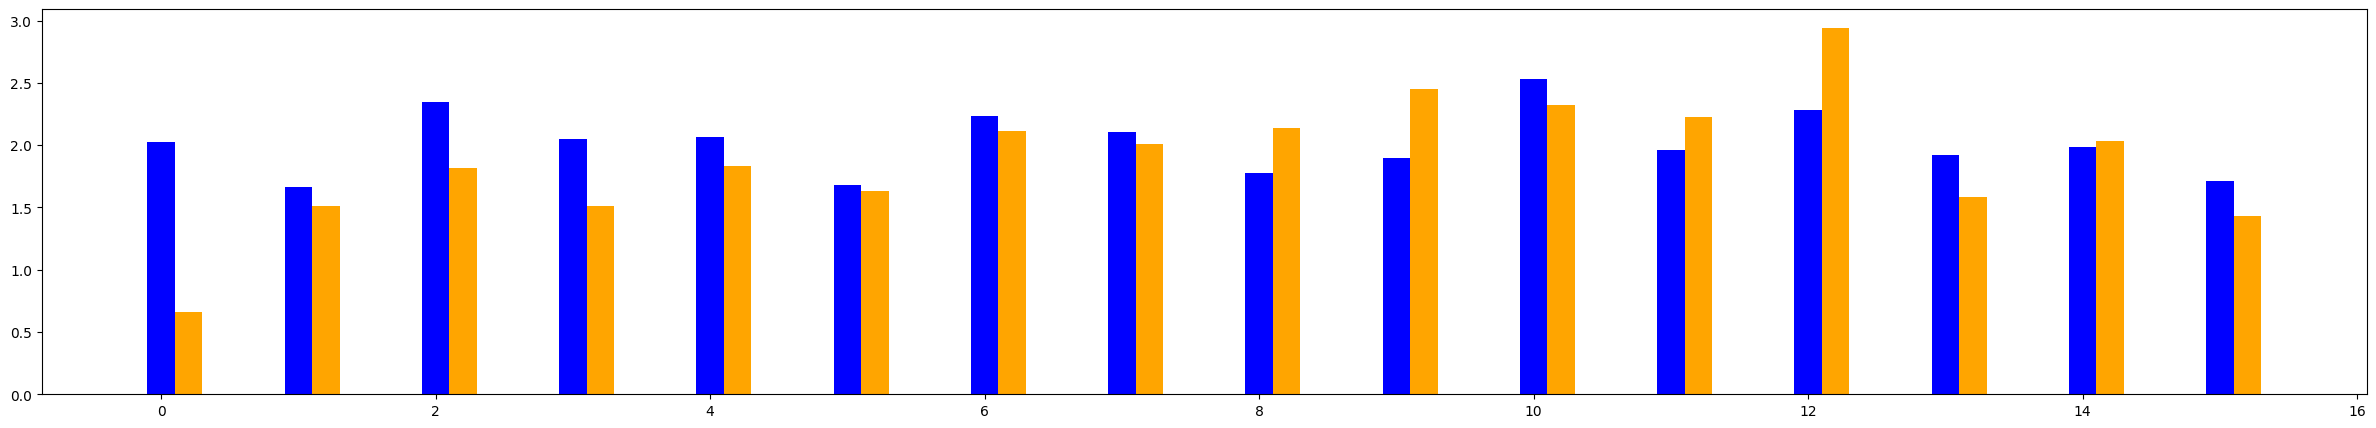

In [43]:
fig, ax = plt.subplots(1,1, figsize=(30, 5))

# time index
l_index = [i for i in range(len(wb_left))]
r_index = [i + 0.2 for i in range(len(wb_right))]

ax.bar(l_index, wb_left,   0.2,  color="blue", label="Left" )
ax.bar(r_index, wb_right,  0.2, color="orange", label="Right" )

### Compute axis contribution

Z axis is forward (anterior posterior)
X axis is up (vertical)
Y axis is side (medio lateral)

In [63]:
def compute_weight_bearing_for_axis(axis,sampling_rate, time_window, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    axis = axis.to_numpy()  / 9.80665
    
    window_samples = time_window * sampling_rate
    
    # chunk the data
    axis_chunks = [axis[i:i + window_samples] for i in range(0, len(axis), window_samples)]
    
    # for each chunk
    li = []
    for idx, chunk in enumerate(axis_chunks):
        filtered_mag = filter_signal(b,a, chunk, "filtfilt")
        fft_mag = compute_fft_mag(filtered_mag)
        li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)
        li.append(li_result)
        
    return li

Text(0, 0.5, 'BW/s')

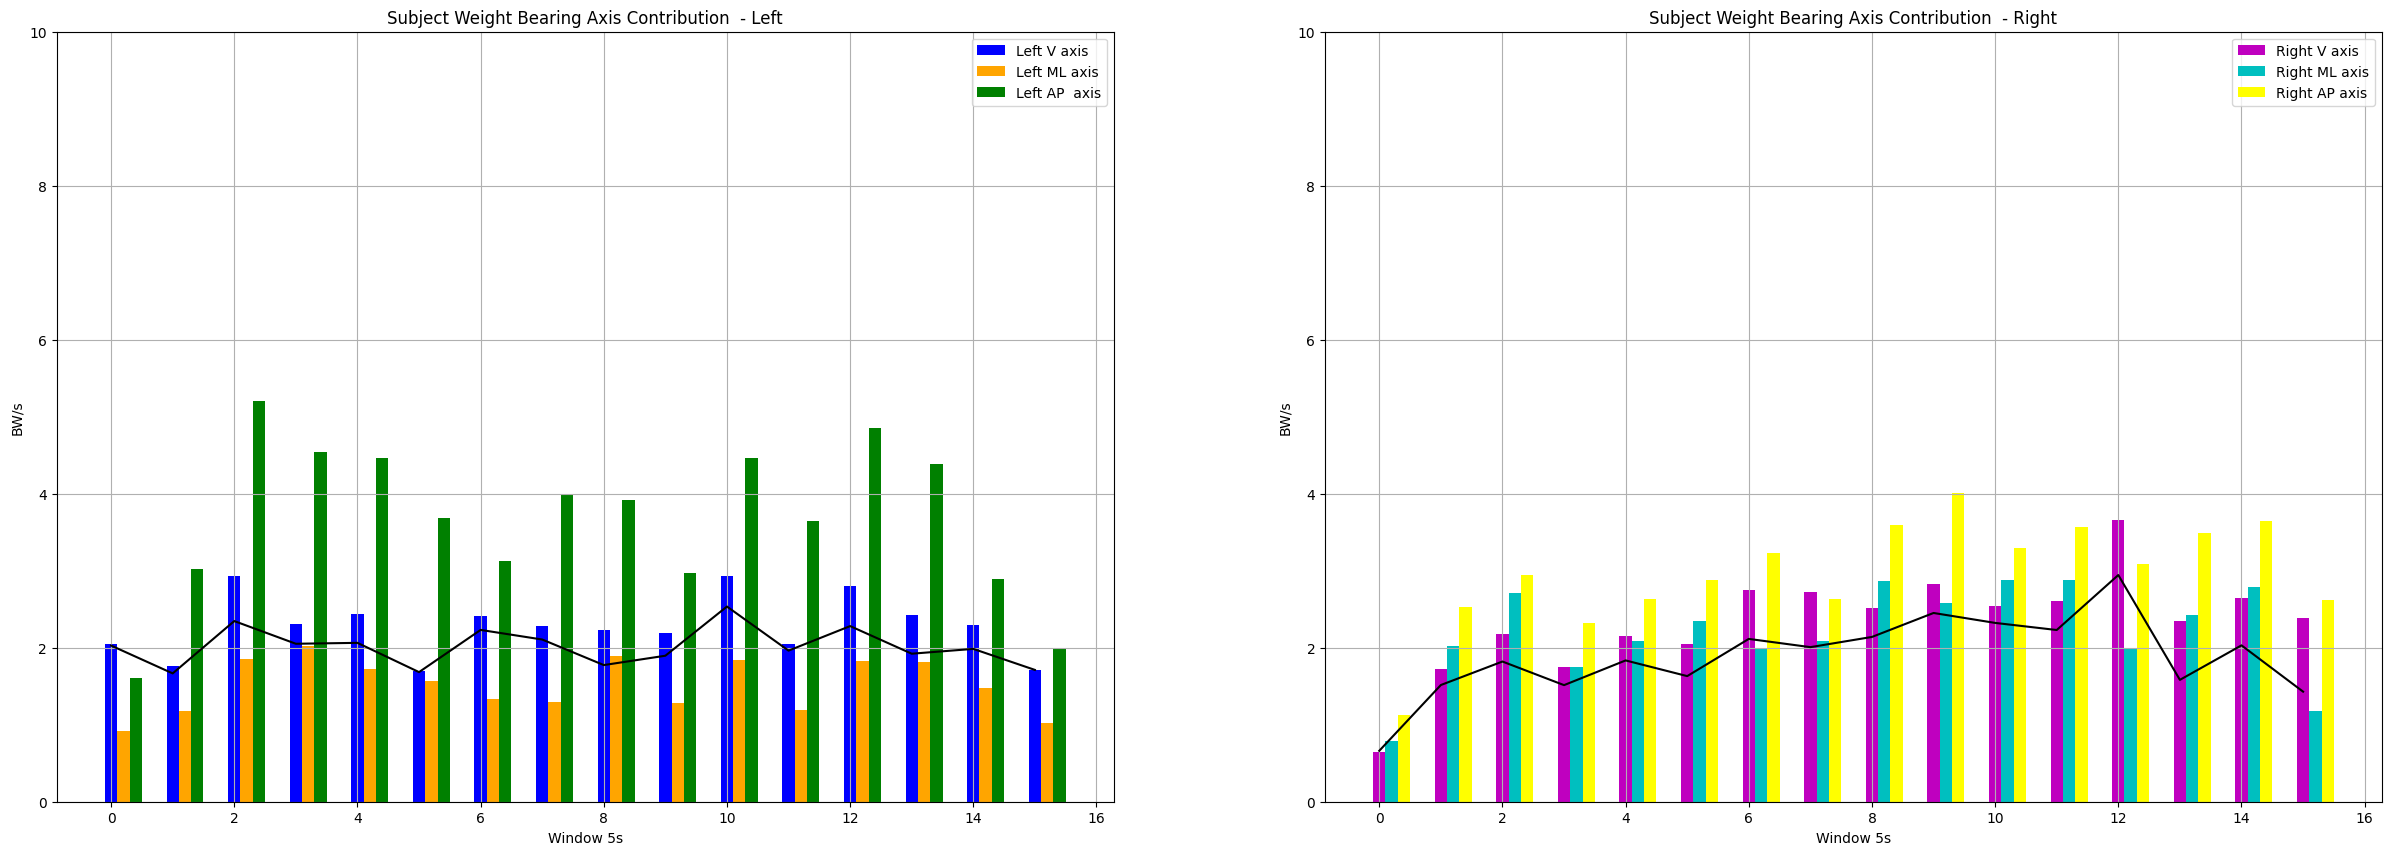

In [71]:
left_axis = [ left_df["Acc_X"],  left_df["Acc_Y"], left_df["Acc_Z"] ]
right_axis = [ right_df["Acc_X"],  right_df["Acc_Y"], right_df["Acc_Z"] ]

# all axis left
l_axis_wb = []
for axis in left_axis:
    l_axis_wb.append(compute_weight_bearing_for_axis(axis,
                sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type) )

r_axis_wb = []
for axis in right_axis:
    r_axis_wb.append(compute_weight_bearing_for_axis(axis,
                sampling_rate, window, low_cut_off, high_cut_off, filter_order, filter_type) )
    

fig, ax = plt.subplots(1,2, figsize=(30, 10))

# time index
l_index_x = [i for i in range(len(l_axis_wb[0]))]
l_index_y = [i + 0.2 for i in range(len(l_axis_wb[1]))]
l_index_z = [i + 0.4 for i in range(len(l_axis_wb[2]))]

ax[0].bar(l_index, l_axis_wb[0],   0.2,  color="blue", label="Left V axis" )
ax[0].bar(l_index_y, l_axis_wb[1],   0.2,  color="orange", label="Left ML axis" )
ax[0].bar(l_index_z, l_axis_wb[2],   0.2,  color="green", label="Left AP  axis" )
ax[0].plot(np.arange(0, len(wb_left)), wb_left, color="black")

ax[1].bar(l_index, r_axis_wb[0],   0.2,  color="m", label="Right V axis" )
ax[1].bar(l_index_y, r_axis_wb[1],   0.2,  color="c", label="Right ML axis" )
ax[1].bar(l_index_z, r_axis_wb[2],   0.2,  color="yellow", label="Right AP axis" )
ax[1].plot(np.arange(0, len(wb_right)), wb_right, color="black")
# graph config

ax[0].set_title(f"Subject Weight Bearing Axis Contribution  - Left")
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel("Window 5s")
ax[0].set_ylim(0, 10)
ax[0].set_ylabel('BW/s')
ax[1].set_title(f"Subject Weight Bearing Axis Contribution  - Right")
ax[1].grid(True)
ax[1].legend()
ax[1].set_xlabel("Window 5s")
ax[1].set_ylim(0, 10)
ax[1].set_ylabel('BW/s')

### Basic stats for window loading

In [83]:
# average loading 
left_avg_wb = np.sum(wb_left) / len(wb_left)
print(f"average load left {left_avg_wb}")

right_avg_wb = np.sum(wb_right) / len(wb_right)
print(f"average load right {right_avg_wb}")

overall_wb = (left_avg_wb + right_avg_wb) / 2
print(f"overall capability {overall_wb}")

print()

# distribution
wb_in_left = (left_avg_wb / (left_avg_wb + right_avg_wb)) * 100
wb_in_right = (right_avg_wb / (left_avg_wb + right_avg_wb)) * 100

print(f"distribution - Left {wb_in_left}% Right {wb_in_right}%")
print(f"difference =  {abs(wb_in_left - wb_in_right)}")

print()

# axis contribution
# r_axis_wb, l_axis_wb are arrays of x,y,z

left_avg_axis = []
for axis in l_axis_wb:
    left_avg_axis.append(np.sum(axis)/len(axis))



right_avg_axis = []
for axis in r_axis_wb:
    right_avg_axis.append(np.sum(axis)/len(axis))

print(f"left:  V {left_avg_axis[0]} ML {left_avg_axis[1]} AP {left_avg_axis[2]}")
print(f"right:  V {right_avg_axis[0]} ML {right_avg_axis[1]} AP {right_avg_axis[2]}")

average load left 2.0152626254009567
average load right 1.889408551261428
overall capability 1.9523355883311924

distribution - Left 51.61158351683669% Right 48.38841648316331%
difference =  3.223167033673377

left:  V 2.2842108349915122 ML 1.5151188606930028 AP 3.673112107614575
right:  V 2.342954686721197 ML 2.2088534531605006 AP 2.974836900029734
